In [27]:
import numpy as np
import glob
import os

import matplotlib.pyplot as plt

from scripts_fermions.operators import Hamiltonian, Boost
import yastn
from yastn.tn import mps

In [28]:
g = 1
v, Q = 1, 1
N = 256
D = 128
a = 0.125
m = 0
#
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/state_t=*.npy")
fnames = glob.glob(glob_path, recursive=True)
fns = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", "dt=0.0625", f"{N=}", f"{D=}", f"{a=:0.4f}", f"{m=:0.4f}"])]);

In [29]:
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/ex/**/state_D=*.npy")
fnames = glob.glob(glob_path, recursive=True)
fex = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", f"{N=}", f"{a=:0.4f}", f"{D=}", f"{m=:0.4f}"])])
fex

['/home/marek/pdf/./results_fermions/g=1.0000/m=0.0000/N=256/a=0.1250/ex/state_D=128.npy']

In [30]:
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/gs/**/state_D=*.npy")
fnames = glob.glob(glob_path, recursive=True)
fgs = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", f"{N=}", f"{a=:0.4f}", f"{D=}", f"{m=:0.4f}"])])
fgs

['/home/marek/pdf/./results_fermions/g=1.0000/m=0.0000/N=256/a=0.1250/gs/state_D=128.npy']

In [31]:
def fn_mass(fns, **kwargs):
    return [x for x in fns if all( f"{k}={v}" in x for k, v in kwargs.items()) ][0]

In [32]:
d_ex = np.load(fn_mass(fex, m=m), allow_pickle=True).item()
d_gs = np.load(fn_mass(fgs, m=m), allow_pickle=True).item()
psi_ex = yastn.from_dict(d_ex['psi'])
psi_gs = yastn.from_dict(d_gs['psi'])

In [33]:
prob_t = {}
ts = np.linspace(0, 16, 17)
psi_t = {t: yastn.from_dict(np.load(fn_mass(fns, t=t), allow_pickle=True).item()['psi']) for t in ts}

In [34]:
prob_gs = {t: np.abs(mps.vdot(xx, psi_gs)) ** 2  for t, xx in psi_t.items()}
prob_ex = {t: np.abs(mps.vdot(xx, psi_ex)) ** 2  for t, xx in psi_t.items()}

In [43]:
ops = yastn.operators.SpinlessFermions(sym='U1', tensordot_policy='no_fusion')
K = Boost(N, m, g, a, ops)
H = Hamiltonian(N, m, g, t=0, a=a, v=1, Q=0, ops=ops)

psi = psi_ex.copy()

opts_svd={"D_total": 64}
chis = np.linspace(0, 1, 21)

opts_expmv = {'hermitian': True, 'tol': 1e-10}
evol = mps.tdvp_(psi, K, chis, method='12site', opts_svd=opts_svd, dt=0.05, yield_initial=True, precompute=False, subtract_E=True, opts_expmv=opts_expmv)

EE = []
EE2 = []

probs = {}

for info in evol:
    EE.append(mps.vdot(psi, H, psi))
    EE2.append(mps.vdot(psi, H @ H, psi))
    chi = info.tf
    probs[chi] = {t: np.abs(mps.vdot(xx, psi)) ** 2  for t, xx in psi_t.items()}
    print(f"{info.tf:0.2f}", EE[-1].real, EE2[-1].real - (EE[-1].real) ** 2)

0.00 -644.4618759301984 9.91043634712696e-07
0.05 -644.4609612893101 0.00033608125522732735
0.10 -644.4584730696547 0.0005797094199806452
0.15 -644.4544701217512 0.0008322754874825478
0.20 -644.4489797187783 0.0010821245959959924
0.25 -644.442001482365 0.001331834529992193
0.30 -644.4335129478461 0.001594721048604697
0.35 -644.4234784569696 0.0018868709448724985
0.40 -644.4118564696784 0.0022249138564802706
0.45 -644.3986044330859 0.0026221484877169132
0.50 -644.3836808933283 0.0030885387677699327
0.55 -644.36704560221 0.0036318222410045564
0.60 -644.3486585755137 0.004257652850355953
0.65 -644.3284786032578 0.0049703239928931
0.70 -644.3064616933511 0.005773831449914724
0.75 -644.2825597555275 0.006672306335531175
0.80 -644.2567195228728 0.007672024774365127
0.85 -644.2288820525666 0.008780324540566653
0.90 -644.1989823141505 0.010006814380176365
0.95 -644.1669491951868 0.011362921039108187
1.00 -644.1327056028156 0.012861414870712906


In [44]:
E_ex = mps.vdot(psi_ex, H, psi_ex).real
E_gs = mps.vdot(psi_gs, H, psi_gs).real

Text(0.5, 0, 'chi')

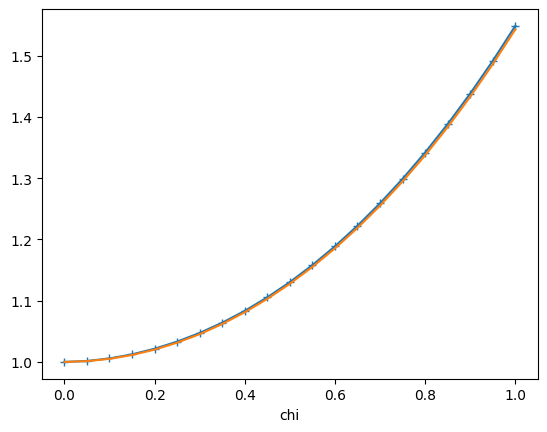

In [45]:
dE = np.array(EE).real - E_gs
plt.plot(chis, dE / dE[0], '-+')
plt.plot(chis, np.cosh(chis))
plt.xlabel("chi")


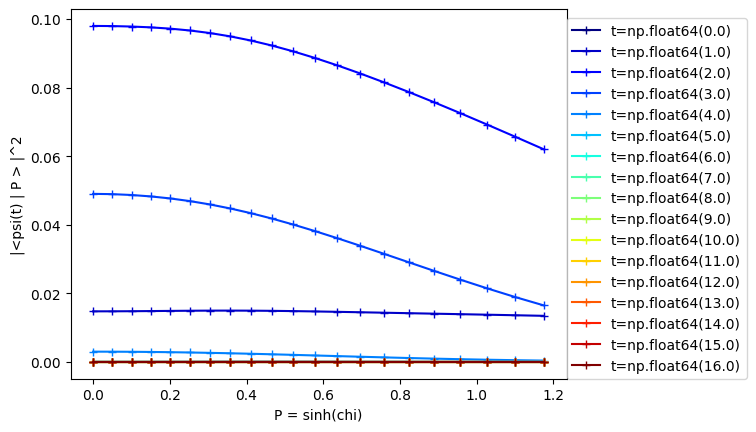

In [46]:
cm = plt.cm.jet
for t in ts:

    pr = [probs[chi][t] for chi in chis]
    P = np.sinh(chis)
    plt.plot(P, pr, '-+', label=f"{t=}", color = cm(t / ts[-1]))
plt.xlabel('P = sinh(chi)')
plt.ylabel("|<psi(t) | P > |^2")
plt.legend(loc=(1, 0))